<a href="https://colab.research.google.com/github/Shifatasmiah/Diabetic-Retinopathy-Classification/blob/main/resnet_with_sqeeze_attention__(1)%2C_(2)next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import pathlib
import pickle
from sklearn.model_selection import KFold

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -q /content/drive/MyDrive/Murgi-Folder/dataset.zip -d /content/dataset

In [ ]:
data_dir = '/content/drive/MyDrive/Diabetic_retinopathy/retinadataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

399


In [ ]:
img_height, img_width = 224, 224
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 399 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
total_classes = len(class_names)
print(total_classes)
print(class_names)

6
['Hypertensive retinopathy', 'Mild NPDR (1)', 'Moderate NPDR (2)', 'NO_DR 0', 'Proliferative DR 4', 'Severe NPDR 3']


In [ ]:
class SqueezeExciteBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SqueezeExciteBlock, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        filters = input_shape[-1]
        self.reshape = tf.keras.layers.Reshape((1, filters))
        self.reduce_dim = tf.keras.layers.Dense(filters // self.ratio, activation='relu')
        self.expand_dim = tf.keras.layers.Dense(filters, activation='sigmoid')

    def call(self, inputs):
        if len(inputs.shape) > 2:
            se = self.reshape(tf.reduce_mean(inputs, axis=[1, 2]))
        else:
            se = tf.reduce_mean(inputs, axis=1, keepdims=True)
        se = self.expand_dim(self.reduce_dim(se))
        return tf.multiply(inputs, se)


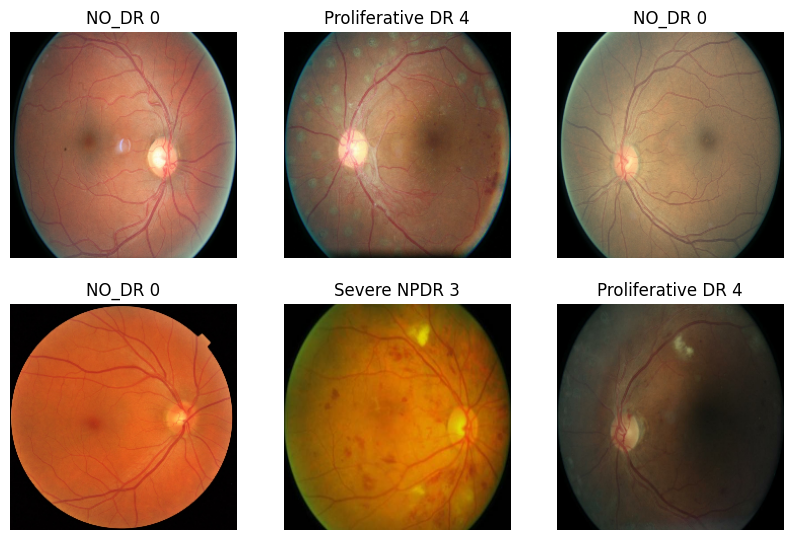

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# convert it to one hot encoded
dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

In [ ]:
# checkpoint and monitor val_accuracy val_precision val_recall val_f1_score
model_name = 'ResNet152'
checkpoint_filepath = '/content/drive/MyDrive/Diabetic_retinopathy/training_checkpoints/' + model_name + '.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    period=25
)

In [ ]:
history_list = []
history_file = "/content/drive/MyDrive/Diabetic_retinopathy/training_history/" + model_name + ".pkl"
if os.path.exists(history_file):
    with open(history_file, "rb") as f:
        history_list = pickle.load(f)
else:
    history_list = []

In [ ]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),

    ])

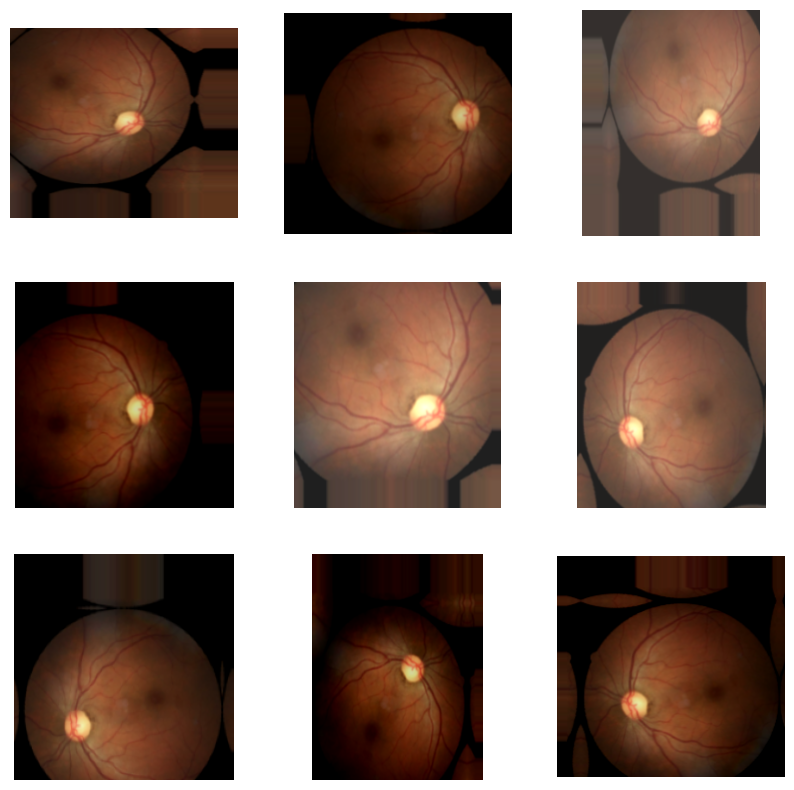

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[3].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 19.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
if os.path.exists(checkpoint_filepath):
    # Load the model from the checkpoint file
    model = tf.keras.saving.load_model(checkpoint_filepath)
    print("Model loaded from checkpoint.")
else:
   pretrained_model = tf.keras.applications.ResNet152(include_top=False,
                                                        input_shape=(img_height, img_width, 3),
                                                        pooling='avg',
                                                        weights='imagenet')

for layer in pretrained_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
    pretrained_model,
    SqueezeExciteBlock(),  # Add attention mechanism here
    Flatten(),
    Dense(512, activation='relu'),
    Dense(total_classes, activation='softmax'),
])


234698864/234698864 [==============================] - 6s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(total_classes,name = 'f1_score')
])

In [ ]:
train_images = []
train_labels = []
for images, labels in dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

fold = 1
for train_index, val_index in kf.split(train_images):
    print(f"Training fold: {fold}")
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    train_fold = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_fold = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

    epochs = 100
    history = model.fit(
    train_fold,
    validation_data=val_fold,
    epochs=epochs,
    # callbacks=[model_checkpoint_callback],
    )

    fold += 1

    history_list.append(history.history)

# with open(history_file, "wb") as f:
#     pickle.dump(history_list, f)


Training fold: 1
Epoch 1/100
10/10 [==============================] - 63s 3s/step - loss: 1.8072 - accuracy: 0.3135 - precision: 0.4107 - recall: 0.1442 - f1_score: 0.3004 - val_loss: 4.3416 - val_accuracy: 0.3250 - val_precision: 0.3333 - val_recall: 0.3000 - val_f1_score: 0.2425
Epoch 2/100
10/10 [==============================] - 18s 2s/step - loss: 1.4632 - accuracy: 0.4263 - precision: 0.5776 - recall: 0.2100 - f1_score: 0.3865 - val_loss: 3.1940 - val_accuracy: 0.2625 - val_precision: 0.2540 - val_recall: 0.2000 - val_f1_score: 0.1240
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 1.2317 - accuracy: 0.4702 - precision: 0.6090 - recall: 0.2539 - f1_score: 0.3895 - val_loss: 8.0283 - val_accuracy: 0.2250 - val_precision: 0.2250 - val_recall: 0.2250 - val_f1_score: 0.0766
Epoch 4/100
10/10 [==============================] - 10s 1s/step - loss: 1.1832 - accuracy: 0.5235 - precision: 0.6438 - recall: 0.2947 - f1_score: 0.5264 - val_loss: 1.9514 - val_accuracy

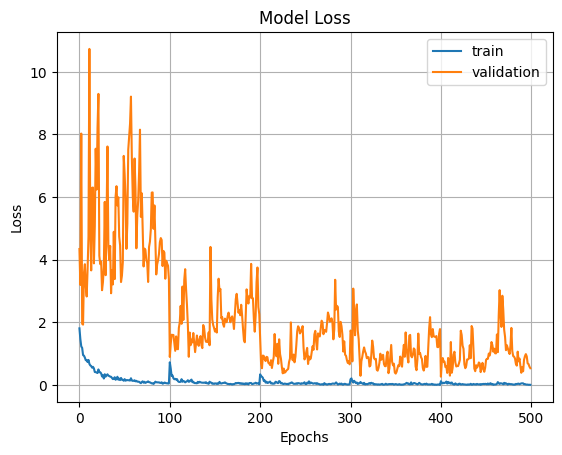

In [ ]:
combined_history = {}
for metric in history_list[0].keys():
    combined_history[metric] = []
    for hist in history_list:
        combined_history[metric].extend(hist[metric])

# Plot the combined history
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

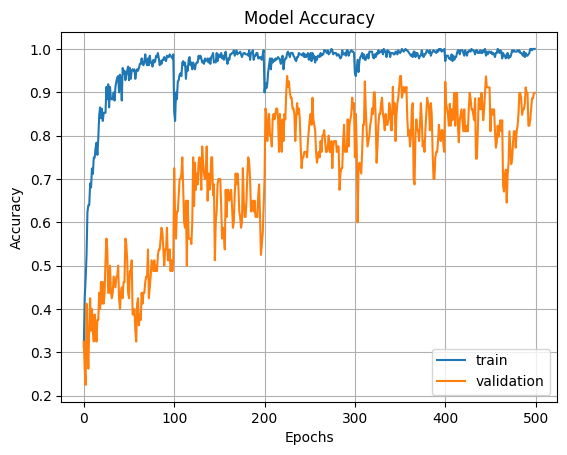

In [ ]:
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

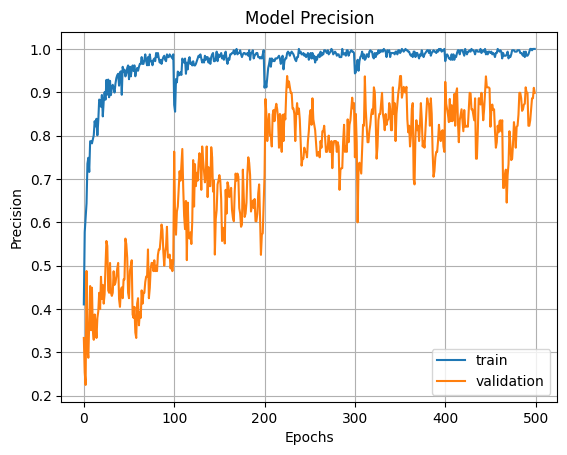

In [ ]:
plt.plot(combined_history['precision'])
plt.plot(combined_history['val_precision'])
plt.grid()
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

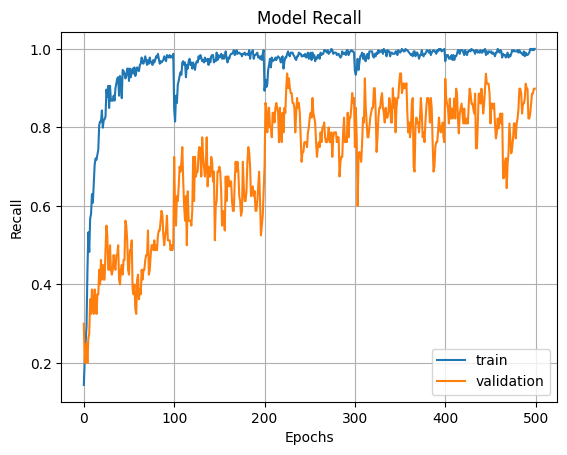

In [ ]:
plt.plot(combined_history['recall'])
plt.plot(combined_history['val_recall'])
plt.grid()
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:


test_data_dir = '/content/drive/MyDrive/testdata/testdata/testdata'
test_data_dir = pathlib.Path(test_data_dir)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# convert it to one hot encoded
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


Found 81 files belonging to 6 classes.


In [ ]:
predictions = model.predict(test_images)


3/3 [==============================] - 4s 654ms/step


In [ ]:
test_labels = np.argmax(test_labels, axis=-1)
predictions = np.argmax(predictions, axis=-1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")


Test Accuracy: 0.9382716049382716
Test Precision: 0.9583333333333334
Test Recall: 0.9349446849446851
Test F1-Score: 0.94175356487258


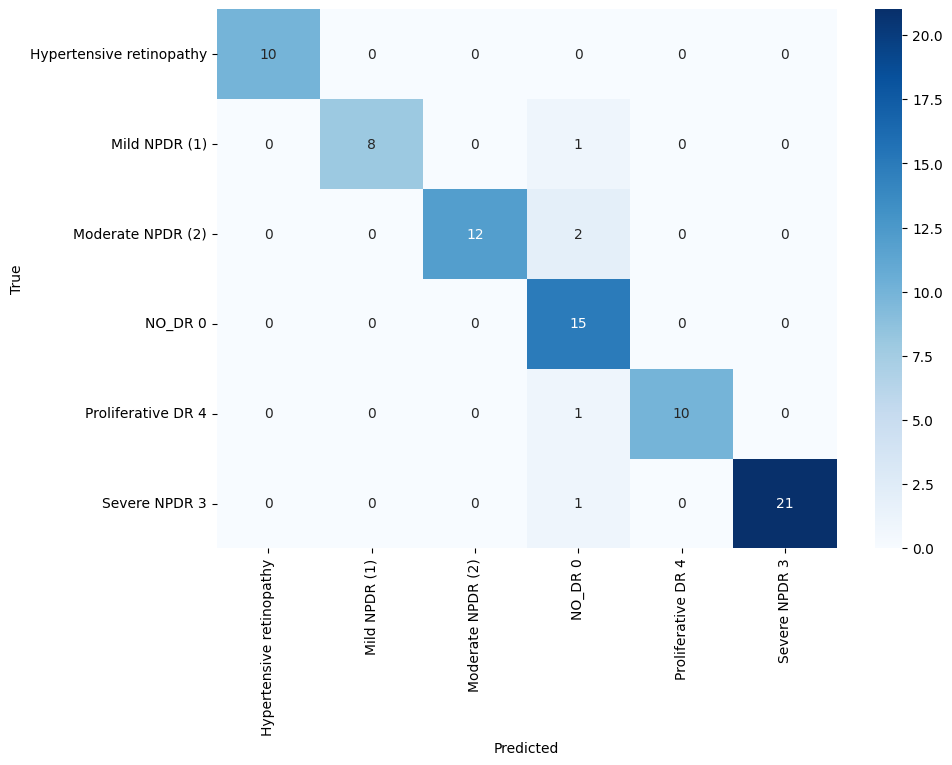

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions, target_names=class_names))


                          precision    recall  f1-score   support

Hypertensive retinopathy       1.00      1.00      1.00        10
           Mild NPDR (1)       1.00      0.89      0.94         9
       Moderate NPDR (2)       1.00      0.86      0.92        14
                 NO_DR 0       0.75      1.00      0.86        15
      Proliferative DR 4       1.00      0.91      0.95        11
           Severe NPDR 3       1.00      0.95      0.98        22

                accuracy                           0.94        81
               macro avg       0.96      0.93      0.94        81
            weighted avg       0.95      0.94      0.94        81

